In [3]:
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow.keras.backend as kb
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing


# np.set_printoptions(threshold=np.inf) #numpy shows full array

In [4]:
# Read Raw Data
rawDataFileName = 'AnalyzedData/nnDataSource.csv'
pitchControlFileName = 'AnalyzedData/spaceValues.csv'
rawData = pd.read_csv(rawDataFileName, header=0, index_col=0)
pitchControlData = pd.read_csv(pitchControlFileName, header=0, index_col=0)
# display(rawData)

# Select Usable Data
rawCols = rawData.columns
cols = rawCols[4:]
xCols = cols[:-1]
yCols = ["18"]
usableData = rawData[cols]

xr = usableData[xCols[0]].to_numpy()
yr = usableData[xCols[1]].to_numpy()
vr = usableData[xCols[2]].to_numpy()
ar = usableData[xCols[3]].to_numpy()
orir = usableData[xCols[5]].to_numpy()
dirr = usableData[xCols[6]].to_numpy()
xt = usableData[xCols[7]].to_numpy()
yt = usableData[xCols[8]].to_numpy()
vt = usableData[xCols[9]].to_numpy()
at = usableData[xCols[10]].to_numpy()
orit = usableData[xCols[12]].to_numpy()
dirt = usableData[xCols[13]].to_numpy()
suc = usableData[yCols[0]].to_numpy()

nRow = xr.shape[0]
nFeature = usableData.shape[1]
print(xr.shape)
print(nFeature)

(7120,)
15


In [5]:
# Data Manipulation

# Change to relative position, vectorized speed, gradient angle
relData = pd.DataFrame()

orir = -np.gradient(orir - 90)
dirr = -np.gradient(dirr - 90)
orit = -np.gradient(orit - 90)
dirt = -np.gradient(dirt - 90)

relData['x0'] = xr
relData['y0'] = yr
relData['x1'] = xt - xr
relData['y1'] = yt - yr
relData['vx0'] = vr * np.cos(dirr)
relData['vy0'] = vr * np.sin(dirr)
relData['vx1'] = vt * np.cos(dirt)
relData['vy1'] = vt * np.sin(dirt)
relData['a0'] = ar
relData['a1'] = at
relData['dir0'] = dirr
relData['dir1'] = dirt
relData['ori0'] = orir
relData['ori1'] = orit
relData['pc'] = pitchControlData['pitch control']

# Normalize for NN
# relNData = preprocessing.normalize(relData) # ~ N(0, 1)
min_max_scaler = preprocessing.MinMaxScaler() 
relNData = min_max_scaler.fit_transform(X=relData) # to range [0, 1]

relData_full = relData
relData_full['Y'] = suc 
relNData_full = min_max_scaler.fit_transform(X=relData) # to range [0, 1]

print(relNData, '\n')
print(relNData_full)

[[0.52740522 0.94989179 0.15436242 ... 0.35558949 0.40749096 0.41794848]
 [0.76671243 0.76926919 0.16778523 ... 0.49154436 0.20570334 0.59625618]
 [0.51209209 0.94023639 0.9261745  ... 0.82730975 0.32090516 0.3874955 ]
 ...
 [0.72637026 0.66256035 0.33892617 ... 0.55704024 0.76213379 0.47323239]
 [0.80114056 0.56067921 0.12751678 ... 0.49291592 0.58209548 0.38734098]
 [0.79395924 0.5365407  0.17449664 ... 0.29566472 0.70556856 0.44392507]] 

[[0.52740522 0.94989179 0.15436242 ... 0.40749096 0.41794848 0.        ]
 [0.76671243 0.76926919 0.16778523 ... 0.20570334 0.59625618 0.        ]
 [0.51209209 0.94023639 0.9261745  ... 0.32090516 0.3874955  1.        ]
 ...
 [0.72637026 0.66256035 0.33892617 ... 0.76213379 0.47323239 1.        ]
 [0.80114056 0.56067921 0.12751678 ... 0.58209548 0.38734098 0.        ]
 [0.79395924 0.5365407  0.17449664 ... 0.70556856 0.44392507 1.        ]]


In [9]:
# EDA
# from sklearn.decomposition import PCA

# pca = PCA(n_components=nFeature+1)
# pca.fit(relNData_full)

# print('PCA explained variance ratio:', '\n', pca.explained_variance_ratio_, '\n')
# print('PCA singular values:', '\n', pca.singular_values_, '\n')

# corr_matrix = np.corrcoef(relNData_full.T)
# print('Shape of covariance matrix is:', corr_matrix.shape)
# print('Correlation between all input features and Y:', '\n', np.round(corr_matrix[15]*100, ), '\n')

type(suc)

numpy.ndarray

In [6]:
# Randomly selecting training data

np.random.seed(seed=1)

# indexes
Ntotal = relNData.shape[0]
trainingIndex = np.random.choice(Ntotal, int(Ntotal * 0.9), replace=False)
validationIndex = np.setdiff1d(np.array(range(Ntotal)), trainingIndex)

# data seperation
tXSet = relNData[trainingIndex]
tYSet = suc[trainingIndex]
vXSet = relNData[validationIndex]
vYSet = suc[validationIndex]

print('Number of features is:', nFeature)
print('Training set has', len(tYSet), 'frames.')
print('Training set tackling rate is:', round(sum(tYSet)/len(tYSet)*100, 4), '%')
print('Validation set has', len(vYSet), 'frames.')
print('Validation set tackling rate is:', round(sum(vYSet)/len(vYSet)*100, 4), '%')

Number of features is: 15
Training set has 6408 frames.
Training set tackling rate is: 77.0911 %
Validation set has 712 frames.
Validation set tackling rate is: 77.6685 %


In [8]:
# Construct NN Model
layers = [keras.layers.Dense(60, activation='relu', input_dim=nFeature),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(30, activation='relu'),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(30, activation='relu'),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(15, activation='relu'),
          keras.layers.Dropout(0.2),
#           keras.layers.Dense(30, activation='relu'),
#           keras.layers.Dropout(0.2),
#           keras.layers.Dense(30, activation='relu'),
#           keras.layers.Dropout(0.2),
#           keras.layers.Dense(15, activation='relu'),
#           keras.layers.Dropout(0.2),
#           keras.layers.Dense(30, activation='relu'),
#           keras.layers.Dropout(0.2),
#           keras.layers.Dense(30, activation='relu'),
#           keras.layers.Dropout(0.2),
#           keras.layers.Dense(15, activation='relu'),
#           keras.layers.Dropout(0.2),
          keras.layers.Dense(1, activation='sigmoid')
         ]
model = keras.Sequential(layers)

# compile model
sgd = keras.optimizers.SGD(learning_rate=0.1, momentum=0.8) # use stochastic gradient descent as optimizer

model.compile(loss='binary_crossentropy',
              optimizer=sgd, 
              metrics=['accuracy'])

Epoch 1/4000
201/201 [==============================] - 0s 765us/step - loss: 0.4200 - accuracy: 0.7953 - val_loss: 0.5328 - val_accuracy: 0.7767
Epoch 2/4000
201/201 [==============================] - 0s 621us/step - loss: 0.4249 - accuracy: 0.7984 - val_loss: 0.5457 - val_accuracy: 0.7472
Epoch 3/4000
201/201 [==============================] - 0s 623us/step - loss: 0.4148 - accuracy: 0.7987 - val_loss: 0.5432 - val_accuracy: 0.7823
Epoch 4/4000
201/201 [==============================] - 0s 649us/step - loss: 0.4202 - accuracy: 0.7956 - val_loss: 0.5574 - val_accuracy: 0.7669
Epoch 5/4000
201/201 [==============================] - 0s 605us/step - loss: 0.4317 - accuracy: 0.7910 - val_loss: 0.5149 - val_accuracy: 0.7795
Epoch 6/4000
201/201 [==============================] - 0s 616us/step - loss: 0.4189 - accuracy: 0.7979 - val_loss: 0.5185 - val_accuracy: 0.7654
Epoch 7/4000
201/201 [==============================] - 0s 606us/step - loss: 0.4219 - accuracy: 0.7996 - val_loss: 0.5466 -

201/201 [==============================] - 0s 626us/step - loss: 0.4197 - accuracy: 0.8018 - val_loss: 0.5733 - val_accuracy: 0.7654
Epoch 112/4000
201/201 [==============================] - 0s 615us/step - loss: 0.4081 - accuracy: 0.8054 - val_loss: 0.5647 - val_accuracy: 0.7739
Epoch 113/4000
201/201 [==============================] - 0s 621us/step - loss: 0.4156 - accuracy: 0.8023 - val_loss: 0.5286 - val_accuracy: 0.7753
Epoch 114/4000
201/201 [==============================] - 0s 623us/step - loss: 0.4179 - accuracy: 0.8007 - val_loss: 0.5169 - val_accuracy: 0.7795
Epoch 115/4000
201/201 [==============================] - 0s 620us/step - loss: 0.4116 - accuracy: 0.8060 - val_loss: 0.5395 - val_accuracy: 0.7823
Epoch 116/4000
201/201 [==============================] - 0s 612us/step - loss: 0.4142 - accuracy: 0.8002 - val_loss: 0.5240 - val_accuracy: 0.7837
Epoch 117/4000
201/201 [==============================] - 0s 627us/step - loss: 0.4126 - accuracy: 0.7992 - val_loss: 0.5313 - 

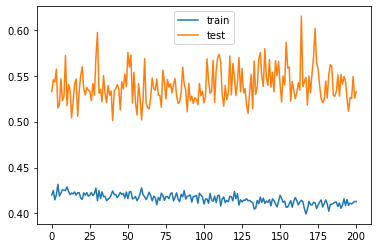

In [14]:
# RUN MODEL

# Early Stopping based on validation loss
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, min_delta=1)
mc = keras.callbacks.ModelCheckpoint('best_model.SB', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

historyData = model.fit(tXSet, tYSet, validation_data=(vXSet, vYSet),
                        epochs=4000,
                        callbacks=[es], 
                        verbose=1)

_, train_acc = model.evaluate(tXSet, tYSet, verbose=0)
_, test_acc = model.evaluate(vXSet, vYSet, verbose=0)
print('Training Accuracy: %.3f, Testing Accuracy: %.3f' % (train_acc, test_acc))

plt.plot(historyData.history['loss'], label='train')
plt.plot(historyData.history['val_loss'], label='test')
plt.legend()
plt.show()